# ◆Forex forecast USD／JPY
### Based on [USD / JPY daily forecast](https://stooq.com/q/d/?s=usdjpy&c=0), we predict whether the closing price of the next day will rise or fall.
- Create Date：2020/02/06　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

#### 【table of contents】
- 0.[**Import module**](#Import_module)
- 1.[**Import data**](#Import_data)
- 3.[**Preprocessing**](#Preprocessing)
- 4.[**Modeling**](#Modeling)

###### ※usdjpy_d.csv

| No | Column | ColumnName | Missing | use |
|:---:|:---:|:---:|:---:|:---:|
|  1 | Date| 日付 | - | ○ |
|  2 | Open |始値 | - | ○ |
|  3 | High |高値 | - | ○ |
|  4 | Low |底値 | - | ○ |
|  5 | Close |終値 | - | ○ |

## 0. Import module<a id='Import_module'></a>

- QRNN(Quasi-Recurrent-Neural-Network)[GitHub](https://github.com/DingKe/nn_playground/blob/master/qrnn/qrnn.py)

**QRNN(Quasi-Recurrent-Neural-Network:準再発ニューラルネットワーク)とは**

2016年11月にSales Force研究所のJames Bradburyらによって発表された学習手法です．
単語の連続で表現される文章や，波形の連続である音声等，時間軸方向に情報を持つデータを学習させる際には，過去から未来に向けて計算結果を順々に伝播させていく手法がよいとされています．
RNNの一手法であるLSTMでは，ネットワークを構成する隠れ層によって，過去の出力値と媒介変数から現在の出力，媒介変数を算出し，それを伝播させていくという手法をとっていました．
しかし，この方法では，現在の出力を得るために過去の出力値と媒介変数の値の両方が必要になるため，並列計算ができず計算に時間がかかるという問題点がありました．

そこでQRNNでは，CNNの並列計算能力を部分的に活用し，時系列データ学習高速化を行なっています．QRNNの論文はこちらで読むことができ，chainerやtensorflowを用いた実装もgithubにて公開されています．今回はこちらのKerasによる実装コードを用いることとします．

In [1]:
# -*- coding: utf-8 -*-
from __future__ import absolute_import
import numpy as np

from keras import backend as K
from keras import activations, initializers, regularizers, constraints
from keras.layers import Layer, InputSpec

from keras.utils.conv_utils import conv_output_length

import theano
import theano.tensor as T


def _dropout(x, level, noise_shape=None, seed=None):
    x = K.dropout(x, level, noise_shape, seed)
    x *= (1. - level) # compensate for the scaling by the dropout
    return x


class QRNN(Layer):
    '''Quasi RNN
    # Arguments
        units: dimension of the internal projections and the final output.
    # References
        - [Quasi-recurrent Neural Networks](http://arxiv.org/abs/1611.01576)
    '''
    def __init__(self, units, window_size=2, stride=1,
                 return_sequences=False, go_backwards=False, 
                 stateful=False, unroll=False, activation='tanh',
                 kernel_initializer='uniform', bias_initializer='zero',
                 kernel_regularizer=None, bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None, 
                 dropout=0, use_bias=True, input_dim=None, input_length=None,
                 **kwargs):
        self.return_sequences = return_sequences
        self.go_backwards = go_backwards
        self.stateful = stateful
        self.unroll = unroll

        self.units = units 
        self.window_size = window_size
        self.strides = (stride, 1)

        self.use_bias = use_bias
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.recurrent_dropout = 0 #not used, added to maintain compatibility with keras.Bidirectional
        self.dropout = dropout
        self.supports_masking = True
        self.input_spec = [InputSpec(ndim=3)]
        self.input_dim = input_dim
        self.input_length = input_length
        if self.input_dim:
            kwargs['input_shape'] = (self.input_length, self.input_dim)
        super(QRNN, self).__init__(**kwargs)

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        batch_size = input_shape[0] if self.stateful else None
        self.input_dim = input_shape[2]
        self.input_spec = InputSpec(shape=(batch_size, None, self.input_dim))
        self.state_spec = InputSpec(shape=(batch_size, self.units))

        self.states = [None]
        if self.stateful:
            self.reset_states()

        kernel_shape = (self.window_size, 1, self.input_dim, self.units * 3)
        self.kernel = self.add_weight(name='kernel',
                                      shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(name='bias', 
                                        shape=(self.units * 3,),
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)

        self.built = True

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        length = input_shape[1]
        if length:
            length = conv_output_length(length + self.window_size - 1,
                                        self.window_size, 'valid',
                                        self.strides[0])
        if self.return_sequences:
            return (input_shape[0], length, self.units)
        else:
            return (input_shape[0], self.units)

    def compute_mask(self, inputs, mask):
        if self.return_sequences:
            return mask
        else:
            return None

    def get_initial_states(self, inputs):
        # build an all-zero tensor of shape (samples, units)
        initial_state = K.zeros_like(inputs)  # (samples, timesteps, input_dim)
        initial_state = K.sum(initial_state, axis=(1, 2))  # (samples,)
        initial_state = K.expand_dims(initial_state)  # (samples, 1)
        initial_state = K.tile(initial_state, [1, self.units])  # (samples, units)
        initial_states = [initial_state for _ in range(len(self.states))]
        return initial_states

    def reset_states(self, states=None):
        if not self.stateful:
            raise AttributeError('Layer must be stateful.')
        if not self.input_spec:
            raise RuntimeError('Layer has never been called '
                               'and thus has no states.')

        batch_size = self.input_spec.shape[0]
        if not batch_size:
            raise ValueError('If a QRNN is stateful, it needs to know '
                             'its batch size. Specify the batch size '
                             'of your input tensors: \n'
                             '- If using a Sequential model, '
                             'specify the batch size by passing '
                             'a `batch_input_shape` '
                             'argument to your first layer.\n'
                             '- If using the functional API, specify '
                             'the time dimension by passing a '
                             '`batch_shape` argument to your Input layer.')

        if self.states[0] is None:
            self.states = [K.zeros((batch_size, self.units))
                           for _ in self.states]
        elif states is None:
            for state in self.states:
                K.set_value(state, np.zeros((batch_size, self.units)))
        else:
            if not isinstance(states, (list, tuple)):
                states = [states]
            if len(states) != len(self.states):
                raise ValueError('Layer ' + self.name + ' expects ' +
                                 str(len(self.states)) + ' states, '
                                 'but it received ' + str(len(states)) +
                                 'state values. Input received: ' +
                                 str(states))
            for index, (value, state) in enumerate(zip(states, self.states)):
                if value.shape != (batch_size, self.units):
                    raise ValueError('State ' + str(index) +
                                     ' is incompatible with layer ' +
                                     self.name + ': expected shape=' +
                                     str((batch_size, self.units)) +
                                     ', found shape=' + str(value.shape))
                K.set_value(state, value)

    def __call__(self, inputs, initial_state=None, **kwargs):
        # If `initial_state` is specified,
        # and if it a Keras tensor,
        # then add it to the inputs and temporarily
        # modify the input spec to include the state.
        if initial_state is not None:
            if hasattr(initial_state, '_keras_history'):
                # Compute the full input spec, including state
                input_spec = self.input_spec
                state_spec = self.state_spec
                if not isinstance(state_spec, list):
                    state_spec = [state_spec]
                self.input_spec = [input_spec] + state_spec

                # Compute the full inputs, including state
                if not isinstance(initial_state, (list, tuple)):
                    initial_state = [initial_state]
                inputs = [inputs] + list(initial_state)

                # Perform the call
                output = super(QRNN, self).__call__(inputs, **kwargs)

                # Restore original input spec
                self.input_spec = input_spec
                return output
            else:
                kwargs['initial_state'] = initial_state
        return super(QRNN, self).__call__(inputs, **kwargs)

    def call(self, inputs, mask=None, initial_state=None, training=None):
        # input shape: `(samples, time (padded with zeros), input_dim)`
        # note that the .build() method of subclasses MUST define
        # self.input_spec and self.state_spec with complete input shapes.
        if isinstance(inputs, list):
            initial_states = inputs[1:]
            inputs = inputs[0]
        elif initial_state is not None:
            pass
        elif self.stateful:
            initial_states = self.states
        else:
            initial_states = self.get_initial_states(inputs)

        if len(initial_states) != len(self.states):
            raise ValueError('Layer has ' + str(len(self.states)) +
                             ' states but was passed ' +
                             str(len(initial_states)) +
                             ' initial states.')
        input_shape = K.int_shape(inputs)
        if self.unroll and input_shape[1] is None:
            raise ValueError('Cannot unroll a RNN if the '
                             'time dimension is undefined. \n'
                             '- If using a Sequential model, '
                             'specify the time dimension by passing '
                             'an `input_shape` or `batch_input_shape` '
                             'argument to your first layer. If your '
                             'first layer is an Embedding, you can '
                             'also use the `input_length` argument.\n'
                             '- If using the functional API, specify '
                             'the time dimension by passing a `shape` '
                             'or `batch_shape` argument to your Input layer.')
        constants = self.get_constants(inputs, training=None)
        preprocessed_input = self.preprocess_input(inputs, training=None)

        last_output, outputs, states = K.rnn(self.step, preprocessed_input,
                                            initial_states,
                                            go_backwards=self.go_backwards,
                                            mask=mask,
                                            constants=constants,
                                            unroll=self.unroll,
                                            input_length=input_shape[1])
        if self.stateful:
            updates = []
            for i in range(len(states)):
                updates.append((self.states[i], states[i]))
            self.add_update(updates, inputs)

        # Properly set learning phase
        if 0 < self.dropout < 1:
            last_output._uses_learning_phase = True
            outputs._uses_learning_phase = True

        if self.return_sequences:
            return outputs
        else:
            return last_output

    def preprocess_input(self, inputs, training=None):
        if self.window_size > 1:
            inputs = K.temporal_padding(inputs, (self.window_size-1, 0))
        inputs = K.expand_dims(inputs, 2)  # add a dummy dimension

        output = K.conv2d(inputs, self.kernel, strides=self.strides,
                          padding='valid',
                          data_format='channels_last')
        output = K.squeeze(output, 2)  # remove the dummy dimension
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')

        if self.dropout is not None and 0. < self.dropout < 1.:
            z = output[:, :, :self.units]
            f = output[:, :, self.units:2 * self.units]
            o = output[:, :, 2 * self.units:]
            f = K.in_train_phase(1 - _dropout(1 - f, self.dropout), f, training=training)
            return K.concatenate([z, f, o], -1)
        else:
            return output

    def step(self, inputs, states):
        prev_output = states[0]

        z = inputs[:, :self.units]
        f = inputs[:, self.units:2 * self.units]
        o = inputs[:, 2 * self.units:]

        z = self.activation(z)
        f = f if self.dropout is not None and 0. < self.dropout < 1. else K.sigmoid(f)
        o = K.sigmoid(o)

        output = f * prev_output + (1 - f) * z
        output = o * output

        return output, [output]

    def get_constants(self, inputs, training=None):
        return []
 
    def get_config(self):
        config = {'units': self.units,
                  'window_size': self.window_size,
                  'stride': self.strides[0],
                  'return_sequences': self.return_sequences,
                  'go_backwards': self.go_backwards,
                  'stateful': self.stateful,
                  'unroll': self.unroll,
                  'use_bias': self.use_bias,
                  'dropout': self.dropout,
                  'activation': activations.serialize(self.activation),
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer': regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'input_dim': self.input_dim,
                  'input_length': self.input_length}
        base_config = super(QRNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Using TensorFlow backend.
C:\Users\arsma\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\arsma\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\arsma\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\arsma\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
%matplotlib inline
import datetime
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# ****************************************************************************
# setting
# ****************************************************************************
train_size = 0.90

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 30)

# 1. Import data<a id='Import_data'></a>

In [3]:
df= pd.read_csv('./input/usdjpy_d.csv',parse_dates=['Date'])

# column name change
df.rename(columns={'Date' : 'time'}, inplace=True)
df.rename(columns={'Open' : 'price_0'}, inplace=True)
df.rename(columns={'High' : 'price_1'}, inplace=True)
df.rename(columns={'Low' : 'price_2'}, inplace=True)
df.rename(columns={'Close' : 'price_3'}, inplace=True)

df = df.query('time >= "2015-01-01"')

display(df.tail(3))

,time,price_0,price_1,price_2,price_3
12553,2020-02-04,108.667,109.545,108.551,109.470
12554,2020-02-05,109.459,109.847,109.307,109.799
12555,2020-02-06,109.803,110.025,109.779,109.990


# 2. Preprocessing<a id='Preprocessing'></a>

In [4]:
# 行数、列数を取得
split_row = np.int(train_size * df.shape[0])
end_row = df.shape[0]

# データ分割
train_df = df[:split_row]
test_df = df[split_row+1:end_row]

print('train_df.shape',train_df.shape)
print('test_df.shape',test_df.shape)

train_df.shape (1187, 5)
test_df.shape (131, 5)


## [正規化](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [5]:
display(test_df.tail(3))

# 正規化（最大1, 最小0）
mms = MinMaxScaler()
mms.fit(pd.concat([train_df, test_df], axis=0).drop(['time'], axis=1))

# ndarray型に変換
train = mms.transform(train_df.drop(['time'], axis=1))
test = mms.transform(test_df.drop(['time'], axis=1))

print('\ntest[-3:]=\n',test[-3:])

,time,price_0,price_1,price_2,price_3
12553,2020-02-04,108.667,109.545,108.551,109.470
12554,2020-02-05,109.459,109.847,109.307,109.799
12555,2020-02-06,109.803,110.025,109.779,109.990



test[-3:]=
 [[0.34039234 0.35953335 0.3713309  0.37069737]
 [0.37128037 0.37139602 0.40103737 0.38349345]
 [0.38469638 0.37838793 0.41958427 0.39092217]]


n日間×4プライスを説明変数とし、次の日の4プライスを目的変数とする。
今回は直前の120件を利用

- 分足＝120件（直前2時間）
- 日足＝120件（直前120日間）

In [6]:
def make_data(price, window):
    inp, out = [], []
    for i in range(len(price) - window):
        inp.append(price[i:i + window])
        out.append(price[i + window])
    X = np.array(inp).reshape(len(inp), window, price.shape[1])
    y = np.array(out).reshape(len(out), price.shape[1])
    return X, y

def make_only_test_data(price, window):
    inp = []
    i = len(price) - window
    inp.append(price[i:i + window])
    X = np.array(inp).reshape(len(inp), window, price.shape[1])
    return X

# 学習データ
X, y = make_data(train, window=120)

# trainとtestの結合データ
X_all, y_all = make_data(np.concatenate([train, test]), window=120)

# 翌日予測用のテストデータ
X_today = make_only_test_data(np.concatenate([train, test]), window=120)

print('説明変数(X)：' + str(X.shape[2]) + '価格' + str(X.shape[1]) + '件分の教師データを' + str(X.shape[0]) + 'セット用意')
print('目的変数(y)：' + str(y.shape[0]) + 'セット分の次の日の' + str(y.shape[1]) + 'プライス')

print('\n▼学習データサイズ')
print('X.shape = ',X.shape)
print('y.shape = ',y.shape)

print('\n▼学習データ＋テストデータのサイズ')
print('X_all.shape = ',X_all.shape)
print('y_all.shape = ',y_all.shape)

print('\n▼直近テストデータ')
print('X_all = \n',X_all[-1:,-5:,])
print('y_all = \n',y_all[-1:,])

print('\n▼直近予測用データ')
print('X_today.shape = ',X_today.shape)
print('X_today = \n',X_today[-1:,-5:,])

説明変数(X)：4価格120件分の教師データを1067セット用意
目的変数(y)：1067セット分の次の日の4プライス

▼学習データサイズ
X.shape =  (1067, 120, 4)
y.shape =  (1067, 4)

▼学習データ＋テストデータのサイズ
X_all.shape =  (1198, 120, 4)
y_all.shape =  (1198, 4)

▼直近テストデータ
X_all = 
 [[[0.35376935 0.34063948 0.3726669  0.34985026]
  [0.35088335 0.34338911 0.36201815 0.3274474 ]
  [0.32760033 0.33023018 0.36256827 0.3394267 ]
  [0.34039234 0.35953335 0.3713309  0.37069737]
  [0.37128037 0.37139602 0.40103737 0.38349345]]]
y_all = 
 [[0.38469638 0.37838793 0.41958427 0.39092217]]

▼直近予測用データ
X_today.shape =  (1, 120, 4)
X_today = 
 [[[0.35088335 0.34338911 0.36201815 0.3274474 ]
  [0.32760033 0.33023018 0.36256827 0.3394267 ]
  [0.34039234 0.35953335 0.3713309  0.37069737]
  [0.37128037 0.37139602 0.40103737 0.38349345]
  [0.38469638 0.37838793 0.41958427 0.39092217]]]


# 6.Modeling<a id='MOdeling'></a>

いよいよRNNを使って学習していきます。
LSTMとQRNNについて、1変量の場合と4変量の場合でそれぞれ学習・予測を行います。
- [参考1](https://recruit.gmo.jp/engineer/jisedai/blog/rnn-fx-google-colaboratory/)
- [参考2](https://qiita.com/yukiB/items/681f68690ffabbf3e1e1)

In [7]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Input, Dense, LSTM
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# ================================================================================
# QRNN（RNNとはリカレントニューラルネットワーク（recurrent neural network）の略）
# ================================================================================
def create_qrnn_model(l_seq, param):
    input_layer = Input(shape=(l_seq, param)) # ★
    qrnn_output_layer = QRNN(64, window_size=120, dropout=0)(input_layer)
    prediction_result = Dense(param)(qrnn_output_layer) # ★
    model = Model(input=input_layer, output=prediction_result)
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

# ================================================================================
# LSTM（long short-term memory：長短期記憶）は、長期依存性を学習できるRNNの亜種
# ================================================================================
def create_rnn_model(l_seq, param):
    # 隠れ層
    hidden_neurons = 10 # ★
    inputs = Input(shape=(l_seq, param,)) # ★
    x = LSTM(hidden_neurons, return_sequences=False)(inputs)
    predictions = Dense(param, activation='linear')(x) # ★
    model = Model(input=inputs, output=predictions)
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    return model

- 一変量の場合は最初の列のプライスを学習しています。
- 多変量の場合は全て使って学習し、評価の時に最初の列のプライスのみを見ます。
- 予測の際は、直前120件を使います。test予測も直前120件を使っており、説明変数は学習に使ったものが含まれていることにご注意下さい。
- また、今回はtrainデータで学習・testデータで予測という2段階になっていますが、使っているモデルは追加学習が可能です。

In [8]:
# ================================================================================
# LSTM(RNN) 1変量
# ================================================================================
rnn_1 = create_rnn_model(X.shape[1], 1)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
# 学習
print('学習：X[:,:,:1].shape = ',X[:,:,:1].shape)
print('学習：y[:,:1].shape = ',y[:,:1].shape)
rnn_1.fit(X[:,:,:1], y[:,:1], batch_size=300, epochs=100, validation_split=0.1, callbacks=[early_stopping], verbose=0)
# 予測
print('予測：X_all[:,:,:1].shape = ',X_all[:,:,:1].shape)
pred_rnn_1 = rnn_1.predict(X_all[:,:,:1])
pred_rnn_1_today = rnn_1.predict(X_today[:,:,:1])
# 予測結果
print('結果：pred_rnn_1.shape = ',pred_rnn_1.shape)
print('結果：pred_rnn_1_today.shape = ',pred_rnn_1_today.shape)





学習：X[:,:,:1].shape =  (1067, 120, 1)
学習：y[:,:1].shape =  (1067, 1)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


予測：X_all[:,:,:1].shape =  (1198, 120, 1)
結果：pred_rnn_1.shape =  (1198, 1)
結果：pred_rnn_1_today.shape =  (1, 1)


In [9]:
# ================================================================================
# LSTM(RNN) 4変量
# ================================================================================
rnn_4 = create_rnn_model(X.shape[1], 4)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
# 学習
print('学習：X.shape = ',X.shape)
print('学習：y.shape = ',y.shape)
rnn_4.fit(X, y, batch_size=300, epochs=100, validation_split=0.1, callbacks=[early_stopping], verbose=0)
# 予測
print('予測：X_all.shape = ',X_all.shape)
pred_rnn_4 = rnn_4.predict(X_all)
pred_rnn_4_today = rnn_4.predict(X_today)
# 予測結果
print('結果：pred_rnn_4.shape = ',pred_rnn_4.shape)
print('結果：pred_rnn_4_today.shape = ',pred_rnn_4_today.shape)

学習：X.shape =  (1067, 120, 4)
学習：y.shape =  (1067, 4)
予測：X_all.shape =  (1198, 120, 4)
結果：pred_rnn_4.shape =  (1198, 4)
結果：pred_rnn_4_today.shape =  (1, 4)


In [10]:
# ================================================================================
# QRNN 1変量
# ================================================================================
qrnn_1 = create_qrnn_model(X.shape[1], 1)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
# 学習
print('学習：X[:,:,:1].shape = ',X[:,:,:1].shape)
print('学習：y[:,:1].shape = ',y[:,:1].shape)
qrnn_1.fit(X[:,:,:1], y[:,:1], batch_size=300, epochs=100, validation_split=0.1, callbacks=[early_stopping], verbose=0)
# 予測
print('予測：X_all[:,:,:1].shape = ',X_all[:,:,:1].shape)
pred_qrnn_1 = qrnn_1.predict(X_all[:,:,:1])
pred_qrnn_1_today = qrnn_1.predict(X_today[:,:,:1])
# 予測結果
print('結果：pred_qrnn_1.shape = ',pred_qrnn_1.shape)
print('結果：pred_qrnn_1_today.shape = ',pred_qrnn_1_today.shape)

学習：X[:,:,:1].shape =  (1067, 120, 1)
学習：y[:,:1].shape =  (1067, 1)
予測：X_all[:,:,:1].shape =  (1198, 120, 1)
結果：pred_qrnn_1.shape =  (1198, 1)
結果：pred_qrnn_1_today.shape =  (1, 1)


In [11]:
# ================================================================================
# QRNN 4変量
# ================================================================================
qrnn_4 = create_qrnn_model(X.shape[1], 4)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
# 学習
print('学習：X.shape = ',X.shape)
print('学習：y.shape = ',y.shape)
qrnn_4.fit(X, y, batch_size=300, epochs=100, validation_split=0.1, callbacks=[early_stopping], verbose=0)
# 予測
print('予測：X_all.shape = ',X_all.shape)
pred_qrnn_4 = qrnn_4.predict(X_all)
pred_qrnn_4_today = qrnn_4.predict(X_today)
# 予測結果
print('結果：pred_qrnn_4.shape = ',pred_qrnn_4.shape)
print('結果：pred_qrnn_4_today.shape = ',pred_qrnn_4_today.shape)

学習：X.shape =  (1067, 120, 4)
学習：y.shape =  (1067, 4)
予測：X_all.shape =  (1198, 120, 4)
結果：pred_qrnn_4.shape =  (1198, 4)
結果：pred_qrnn_4_today.shape =  (1, 4)


In [12]:
# テストデータ件数
n_test = len(test)

# 始値のみ取得
y_train = y_all[:-n_test,:1] # 訓練データ（0～n_testまでとい意味）
y_test = y_all[-n_test:,:1] # テストデータ（後ろからn_test件取得という意味）

print('▼始値のANSER')
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)

▼始値のANSER
y_train.shape (1067, 1)
y_test.shape (131, 1)


# 7. Result

In [13]:
pred_lst_train = np.array([pred_rnn_1[:-n_test,0], pred_rnn_4[:-n_test,0], pred_qrnn_1[:-n_test,0], pred_qrnn_4[:-n_test,0]])
pred_lst_test = np.array([pred_rnn_1[-n_test:,0], pred_rnn_4[-n_test:,0], pred_qrnn_1[-n_test:,0], pred_qrnn_4[-n_test:,0]])

print('pred_lst_train.shape=',pred_lst_train.shape)
print('pred_lst_test.shape=',pred_lst_test.shape)

rmse_train = [np.sqrt(mean_squared_error(y_train, _y)) for _y in pred_lst_train]
rmse_test = [np.sqrt(mean_squared_error(y_test, _y)) for _y in pred_lst_test]

print('rmse_train',rmse_train)
print('rmse_test',rmse_test)

pred_lst_train.shape= (4, 1067)
pred_lst_test.shape= (4, 131)
rmse_train [0.039224301264374574, 0.03073679014652364, 0.04193589877093712, 0.030137853693526603]
rmse_test [0.02471315586128965, 0.01933981443305417, 0.027962308312931346, 0.024935790508136935]


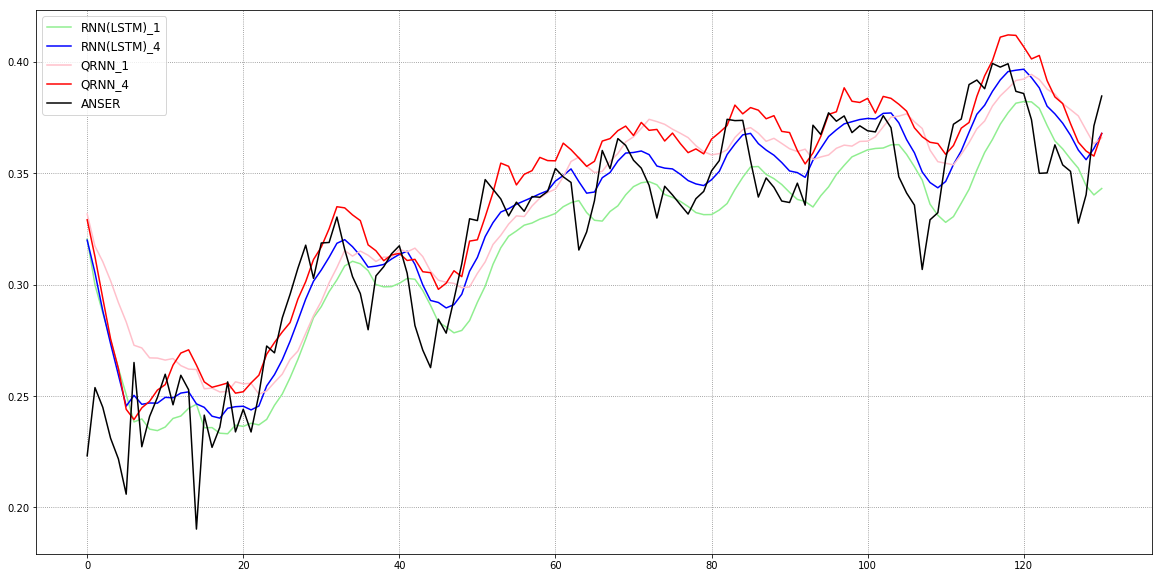

In [14]:

plt.figure(figsize=(20,10))
plt.plot(pred_rnn_1[-n_test:,0], color='lightGreen', label='RNN(LSTM)_1')
plt.plot(pred_rnn_4[-n_test:,0], color='b', label='RNN(LSTM)_4')
plt.plot(pred_qrnn_1[-n_test:,0], color='pink', label='QRNN_1')
plt.plot(pred_qrnn_4[-n_test:,0], color='r', label='QRNN_4')

plt.plot(y_all[-n_test:,0], color='k', label='ANSER')

plt.grid(which='major',color='gray',linestyle=':')
plt.grid(which='minor',color='gray',linestyle=':')
plt.legend(loc='upper left',fontsize=12)
plt.show()


▼直近5件


,time,price_0,price_1,price_2,price_3
12551,2020-01-31,108.936,109.134,108.314,108.358
12552,2020-02-03,108.339,108.799,108.328,108.666
12553,2020-02-04,108.667,109.545,108.551,109.470
12554,2020-02-05,109.459,109.847,109.307,109.799
12555,2020-02-06,109.803,110.025,109.779,109.990



▼直近予測結果
y_inv_pred_rnn_4(青)=
 [[109.07009  109.81129  108.965485 109.454765]
 [109.19958  109.810036 108.94157  109.36857 ]
 [109.37177  109.940544 109.102295 109.5621  ]]
y_inv_pred_qrnn_4(赤)=
 [[109.16955  109.607574 109.02814  109.76297 ]
 [109.1118   109.579994 108.98995  109.62827 ]
 [109.372604 109.61094  109.12644  109.67211 ]]

▼未来予測
y_inv_pred_rnn_4_today(青)=
 [[109.549706 110.137695 109.29479  109.8535  ]]
y_inv_pred_qrnn_4_today(赤)=
 [[109.713264 109.8226   109.29537  109.77893 ]]


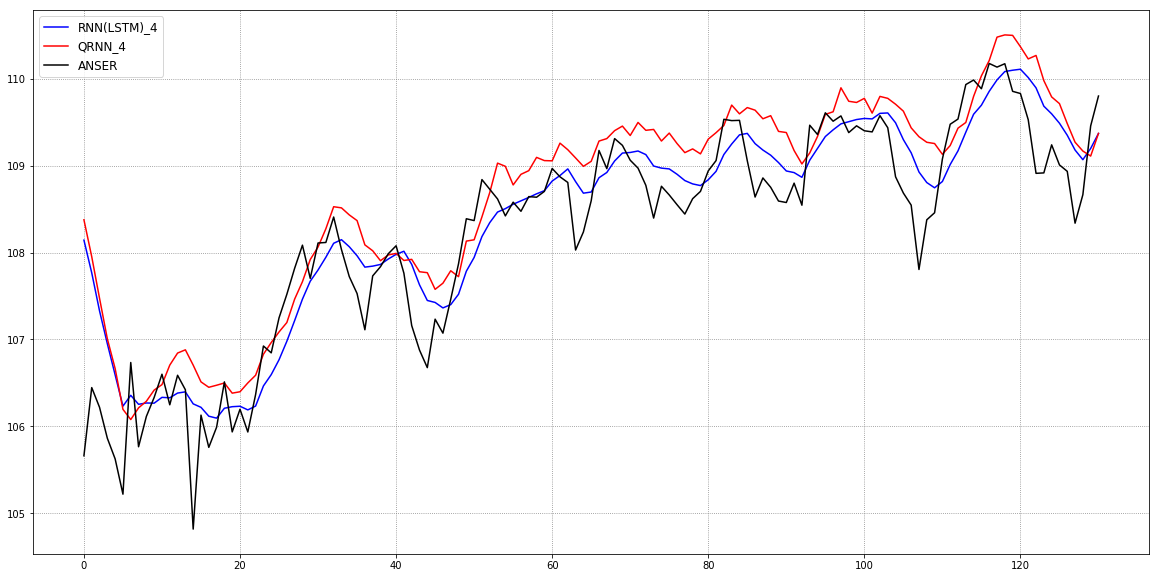

In [15]:
print('▼直近5件')
display(test_df.tail(5))

print('\n▼直近予測結果')
y_inv_pred_rnn_4 = mms.inverse_transform(pred_rnn_4)
print('y_inv_pred_rnn_4(青)=\n',y_inv_pred_rnn_4[-3:,])

y_inv_pred_qrnn_4 = mms.inverse_transform(pred_qrnn_4)
print('y_inv_pred_qrnn_4(赤)=\n',y_inv_pred_qrnn_4[-3:,])

print('\n▼未来予測')
y_inv_pred_rnn_4_today = mms.inverse_transform(pred_rnn_4_today)
print('y_inv_pred_rnn_4_today(青)=\n',y_inv_pred_rnn_4_today)

y_inv_pred_qrnn_4_today = mms.inverse_transform(pred_qrnn_4_today)
print('y_inv_pred_qrnn_4_today(赤)=\n',y_inv_pred_qrnn_4_today)

y_inv_all = mms.inverse_transform(y_all)

plt.figure(figsize=(20,10))
plt.plot(y_inv_pred_rnn_4[-n_test:,0], color='b', label='RNN(LSTM)_4')
plt.plot(y_inv_pred_qrnn_4[-n_test:,0], color='r', label='QRNN_4')
plt.plot(y_inv_all[-n_test:,0], color='k', label='ANSER')

plt.grid(which='major',color='gray',linestyle=':')
plt.grid(which='minor',color='gray',linestyle=':')
plt.legend(loc='upper left',fontsize=12)
plt.show()
